In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path

# Modelling Functions

In [2]:
def load_data(data_dir='csv/input'):
    """
    Load all required datasets from the specified directory
    
    Parameters:
    -----------
    data_dir : str
        Path to the directory containing the input CSV files
    
    Returns:
    --------
    tuple
        Tuple containing gen1_train, gen2_train, gen1_test, gen2_test DataFrames
    """
    data_path = Path(data_dir)
    
    gen1_train = pd.read_csv('gen1_train_comp_final.csv')
    gen2_train = pd.read_csv('gen2_train_comp_final.csv')
    gen1_test = pd.read_csv('gen1_test_comp_final.csv')
    gen2_test = pd.read_csv('gen2_test_upto9_comp_final.csv')
    
    return gen1_train, gen2_train, gen1_test, gen2_test

In [3]:
def prepare_parent_data(gen1_train, gen1_test):
    """
    Prepare parent heights data by combining train and test datasets
    
    Parameters:
    -----------
    gen1_train : DataFrame
        Training data for generation 1 (parents)
    gen1_test : DataFrame
        Test data for generation 1 (parents)
    
    Returns:
    --------
    DataFrame
        Combined parent heights data
    """
    parent_heights_train = (
        gen1_train.dropna(subset=['SHgt_cm'])
        .rename(columns={'age': 'parent_age', 'SHgt_cm': 'parent_height'})
        [['gen1_id', 'parent_age', 'parent_height']]
    )
    
    parent_heights_test = (
        gen1_test.dropna(subset=['SHgt_cm'])
        .rename(columns={'age': 'parent_age', 'SHgt_cm': 'parent_height'})
        [['gen1_id', 'parent_age', 'parent_height']]
    )
    
    return pd.concat([parent_heights_train, parent_heights_test], ignore_index=True)

In [4]:
def create_features(df, parent_data):
    """
    Create features for height prediction with robust NaN handling
    
    Parameters:
    -----------
    df : DataFrame
        Generation 2 data (children)
    parent_data : DataFrame
        Parent heights data
    
    Returns:
    --------
    DataFrame
        Features for model training/prediction
    """
    # Merge with parent data
    merged = pd.merge(
        df,
        parent_data,
        left_on=['study_parent_id_new', 'AgeGr'],
        right_on=['gen1_id', 'parent_age'],
        how='left'
    )
    
    # Extract gender features - categorical to numeric
    merged['is_male'] = (merged['sex_assigned_at_birth'] == 'M').astype(int)
    merged['parent_is_mother'] = (merged['study_parent_sex'] == 'mother').astype(int)
    
    # Parent-child gender interaction
    parent_child_same_gender = ((merged['sex_assigned_at_birth'] == 'M') & 
                              (merged['study_parent_sex'] == 'father')) | \
                             ((merged['sex_assigned_at_birth'] == 'F') & 
                              (merged['study_parent_sex'] == 'mother'))
    merged['parent_child_same_gender'] = parent_child_same_gender.astype(int)
    
    # Calculate BMI if weight data is available (with NaN safety)
    if 'Wgt_kg' in merged.columns:
        # Safe division with proper NaN handling
        merged['bmi'] = np.where(
            (merged['Wgt_kg'].notna()) & (merged['SHgt_cm'].notna()) & (merged['SHgt_cm'] > 0),
            merged['Wgt_kg'] / ((merged['SHgt_cm']/100)**2),
            np.nan
        )

    features = []
    # Process each subject individually
    for subject_id in merged['gen2_id'].unique():
        subject_data = merged[merged['gen2_id'] == subject_id].sort_values('AgeGr')
        
        # Get gender information (these should be consistent within a subject)
        is_male = subject_data['is_male'].iloc[0] if not subject_data.empty else 0
        parent_is_mother = subject_data['parent_is_mother'].iloc[0] if not subject_data.empty else 0
        parent_child_same_gender = subject_data['parent_child_same_gender'].iloc[0] if not subject_data.empty else 0
        
        # Extract early measurements (age <= 9) - with robust filtering
        early_data = subject_data[subject_data['AgeGr'] <= 9]
        early_heights = early_data['SHgt_cm'].values if not early_data.empty else np.array([])
        early_ages = early_data['AgeGr'].values if not early_data.empty else np.array([])
        
        # Extract later measurements (10 <= age <= 18) - with robust filtering
        later_data = subject_data[(subject_data['AgeGr'] >= 10) & (subject_data['AgeGr'] <= 18)]
        later_heights = later_data['SHgt_cm'].values if not later_data.empty else np.array([])
        later_ages = later_data['AgeGr'].values if not later_data.empty else np.array([])

        # Growth velocity calculation with NaN safety
        growth_velocity = np.nan
        if len(early_heights) >= 2 and len(early_ages) >= 2:
            age_diff = early_ages[-1] - early_ages[0]
            if age_diff > 0:  # Prevent division by zero
                growth_velocity = (early_heights[-1] - early_heights[0]) / age_diff

        # Peak Growth Rate calculation with NaN safety
        peak_growth_rate, age_peak_growth = np.nan, np.nan
        if len(later_heights) >= 2 and len(later_ages) >= 2:
            # Calculate growth rates between consecutive measurements
            age_diffs = np.diff(later_ages)
            height_diffs = np.diff(later_heights)
            
            # Only calculate rates where age difference is positive (to avoid division by zero)
            valid_indices = age_diffs > 0
            if np.any(valid_indices):
                growth_rates = np.full_like(age_diffs, np.nan, dtype=float)
                growth_rates[valid_indices] = height_diffs[valid_indices] / age_diffs[valid_indices]
                
                # Find max growth rate if there are valid rates
                if not np.all(np.isnan(growth_rates)):
                    peak_growth_rate = np.nanmax(growth_rates)
                    # Find index of max growth rate
                    max_idx = np.nanargmax(growth_rates)
                    age_peak_growth = later_ages[max_idx + 1]

        # Extract key height measurements with NaN safety
        height_at_6 = subject_data[subject_data['AgeGr'] == 6]['SHgt_cm'].iloc[0] if not subject_data[subject_data['AgeGr'] == 6].empty else np.nan
        height_at_9 = subject_data[subject_data['AgeGr'] == 9]['SHgt_cm'].iloc[0] if not subject_data[subject_data['AgeGr'] == 9].empty else np.nan
        height_at_12 = subject_data[subject_data['AgeGr'] == 12]['SHgt_cm'].iloc[0] if not subject_data[subject_data['AgeGr'] == 12].empty else np.nan
        
        # Parent height at maturity (age 18)
        parent_height_18 = subject_data[subject_data['parent_age'] == 18]['parent_height'].iloc[0] if not subject_data[subject_data['parent_age'] == 18].empty else np.nan

        # Calculate derived features with NaN safety
        height_diff_9_6 = np.nan
        if pd.notna(height_at_9) and pd.notna(height_at_6):
            height_diff_9_6 = height_at_9 - height_at_6
            
        height_diff_12_9 = np.nan
        if pd.notna(height_at_12) and pd.notna(height_at_9):
            height_diff_12_9 = height_at_12 - height_at_9
            
        growth_rate_change = np.nan
        if pd.notna(peak_growth_rate) and pd.notna(growth_velocity):
            growth_rate_change = peak_growth_rate - growth_velocity
            
        parent_child_height_diff = np.nan
        parent_child_height_ratio = np.nan
        if pd.notna(height_at_9) and pd.notna(parent_height_18) and parent_height_18 > 0:
            parent_child_height_diff = height_at_9 - parent_height_18
            parent_child_height_ratio = height_at_9 / parent_height_18
            
        # Get BMI if available
        bmi_at_9 = subject_data[subject_data['AgeGr'] == 9]['bmi'].iloc[0] if 'bmi' in subject_data.columns and not subject_data[subject_data['AgeGr'] == 9].empty else np.nan

        # Create a row for each target age (10-18)
        for target_age in range(10, 19):
            row_data = {
                'gen2_id': subject_id,
                'AgeGr': target_age,
                'last_height': early_heights[-1] if len(early_heights) > 0 else np.nan,
                'last_age': early_ages[-1] if len(early_ages) > 0 else np.nan,
                'growth_velocity': growth_velocity,
                'parent_height_18': parent_height_18,
                'height_at_9': height_at_9,
                'height_diff_9_6': height_diff_9_6,
                'height_diff_12_9': height_diff_12_9,
                'growth_rate_change': growth_rate_change,
                'peak_growth_rate': peak_growth_rate,
                'age_peak_growth': age_peak_growth,
                'parent_child_height_diff': parent_child_height_diff,
                'parent_child_height_ratio': parent_child_height_ratio,
                'is_male': is_male,
                'parent_is_mother': parent_is_mother,
                'parent_child_same_gender': parent_child_same_gender
            }
            
            # Add BMI if available
            if 'bmi' in subject_data.columns:
                row_data['bmi_at_9'] = bmi_at_9
                
            features.append(row_data)
    
    return pd.DataFrame(features)

In [5]:
def prepare_train_data(train_features, gen2_train):
    """
    Add actual height values to training features
    
    Parameters:
    -----------
    train_features : DataFrame
        Features created for training
    gen2_train : DataFrame
        Original gen2 training data with actual heights
    
    Returns:
    --------
    DataFrame
        Training features with actual height values
    """
    train_with_target = pd.merge(
        train_features,
        gen2_train[['gen2_id', 'AgeGr', 'SHgt_cm']],
        on=['gen2_id', 'AgeGr'],
        how='left'
    )
    return train_with_target.dropna(subset=['SHgt_cm'])

In [6]:
def train_model(train_features, feature_cols=None, test_size=0.2, random_state=7):
    """
    Train and evaluate an XGBoost model for height prediction
    
    Parameters:
    -----------
    train_features : DataFrame
        Training features with target variable
    feature_cols : list, optional
        List of feature columns to use
    test_size : float, optional
        Proportion of data to use for validation
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    tuple
        Trained model, preprocessor, and validation metrics
    """
    # Define default feature columns if not provided
    if feature_cols is None:
        feature_cols = [
            'AgeGr', 'last_height', 'growth_velocity', 
            'parent_height_18', 'height_at_9', 'height_diff_9_6', 
            'height_diff_12_9', 'peak_growth_rate', 'age_peak_growth', 
            'parent_child_height_diff', 'parent_child_height_ratio',
            'is_male', 'parent_is_mother', 'parent_child_same_gender'
        ]
        # Add BMI if available
        if 'bmi_at_9' in train_features.columns:
            feature_cols.append('bmi_at_9')
    
    # Split train and validation sets, grouped by subject
    group_split = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, val_idx = next(group_split.split(
        train_features, groups=train_features['gen2_id']
    ))
    
    # Use MICE imputation for better handling of missing values
    preprocessor = Pipeline([
        ('imputer', IterativeImputer(max_iter=10, random_state=random_state)),
        ('scaler', StandardScaler())
    ])
    
    # Preprocess data
    X_train = preprocessor.fit_transform(train_features.iloc[train_idx][feature_cols])
    y_train = train_features.iloc[train_idx]['SHgt_cm'].values
    
    X_val = preprocessor.transform(train_features.iloc[val_idx][feature_cols])
    y_val = train_features.iloc[val_idx]['SHgt_cm'].values
    
    param_grid = {
    'max_depth': [3, 4],  
    'learning_rate': [0.04, 0.05],  
    'min_child_weight': [3, 4],  
    'subsample': [0.65, 0.7],  
    'colsample_bytree': [0.65, 0.7],  
    'gamma': [0.03, 0.05],  
    'n_estimators': [200, 250],  
    'scale_pos_weight': [1.8, 2],  
    'reg_alpha': [0.15, 0.2],  
    'reg_lambda': [0.25, 0.3]  
}

    # Setup cross-validation with group-aware split
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state)
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=4,  # Could use GroupKFold here instead
        scoring='neg_root_mean_squared_error',
        verbose=1
    )
    
    # Run grid search
    grid_search.fit(X_train, y_train, groups=train_features.iloc[train_idx]['gen2_id'])
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    
    # Train the final model with optimal parameters
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'min_child_weight': best_params['min_child_weight'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'random_state': random_state
    }

    evals = [(dtrain, 'train'), (dval, 'eval')]
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=150,
        evals=evals,
        early_stopping_rounds=10,
        verbose_eval=True
    )
    
    # Evaluate the model
    y_val_pred = model.predict(dval, iteration_range=(0, model.best_iteration))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"Validation RMSE: {val_rmse:.2f}")
    print(f"Validation MAE: {val_mae:.2f}")
    print(f"Validation R²: {val_r2:.2f}")
    
    # Create evaluation results
    val_results = pd.DataFrame({
        'gen2_id': train_features.iloc[val_idx]['gen2_id'].values,
        'AgeGr': train_features.iloc[val_idx]['AgeGr'].values,
        'actual': y_val,
        'predicted': y_val_pred,
        'error': y_val - y_val_pred
    })
    
    return model, preprocessor, feature_cols, val_results

In [7]:
def visualize_model(model, val_results, feature_cols=None):
    """
    Create visualizations for model evaluation
    
    Parameters:
    -----------
    model : XGBoost model
        Trained XGBoost model
    val_results : DataFrame
        Validation results with actual and predicted values
    feature_cols : list, optional
        Feature column names for displaying importance
    """
    # Create output directory for visualizations if it doesn't exist
    output_dir = Path('visualizations')
    output_dir.mkdir(exist_ok=True)
    
    # Feature importance
    plt.figure(figsize=(12, 6))
    xgb.plot_importance(model, importance_type='gain', max_num_features=15)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig(output_dir / 'feature_importance.png')
    plt.close()
    
    # Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(val_results['actual'], val_results['predicted'], alpha=0.5)
    plt.plot([val_results['actual'].min(), val_results['actual'].max()], 
             [val_results['actual'].min(), val_results['actual'].max()], 'r--')
    plt.xlabel('Actual Height (cm)')
    plt.ylabel('Predicted Height (cm)')
    plt.title('Actual vs Predicted Heights')
    plt.tight_layout()
    plt.savefig(output_dir / 'actual_vs_predicted.png')
    plt.close()
    
    # Error analysis by age
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='AgeGr', y='error', data=val_results)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Prediction Error by Age')
    plt.xlabel('Age Group')
    plt.ylabel('Error (cm)')
    plt.tight_layout()
    plt.savefig(output_dir / 'error_by_age.png')
    plt.close()
    
    # Error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(val_results['error'], kde=True)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error (cm)')
    plt.tight_layout()
    plt.savefig(output_dir / 'error_distribution.png')
    plt.close()
    
    # ---------- ID-BASED VISUALIZATIONS ----------
    
    # Get unique IDs from validation set
    unique_ids = val_results['gen2_id'].unique()
    
    # Sample up to 10 IDs for individual visualization
    sample_ids = unique_ids[:min(10, len(unique_ids))]
    
    # 1. Individual growth curves with predictions
    plt.figure(figsize=(15, 10))
    
    for subject_id in sample_ids:
        subject_data = val_results[val_results['gen2_id'] == subject_id].sort_values('AgeGr')
        plt.plot(subject_data['AgeGr'], subject_data['actual'], 'o-', label=f'Actual {subject_id}')
        plt.plot(subject_data['AgeGr'], subject_data['predicted'], 'x--', label=f'Predicted {subject_id}')
    
    plt.xlabel('Age')
    plt.ylabel('Height (cm)')
    plt.title('Individual Growth Curves: Actual vs Predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_dir / 'individual_growth_curves.png')
    plt.close()
    
    # 2. Individual growth curves in separate plots
    for subject_id in sample_ids:
        plt.figure(figsize=(12, 6))
        subject_data = val_results[val_results['gen2_id'] == subject_id].sort_values('AgeGr')
        
        plt.plot(subject_data['AgeGr'], subject_data['actual'], 'o-', color='blue', label='Actual')
        plt.plot(subject_data['AgeGr'], subject_data['predicted'], 'x--', color='red', label='Predicted')
        
        # Calculate error
        for i, row in subject_data.iterrows():
            plt.plot([row['AgeGr'], row['AgeGr']], [row['actual'], row['predicted']], 'k-', alpha=0.3)
        
        plt.xlabel('Age')
        plt.ylabel('Height (cm)')
        plt.title(f'Subject {subject_id}: Growth Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(output_dir / f'growth_curve_id_{subject_id}.png')
        plt.close()
    
    # 3. Error analysis by ID
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='gen2_id', y='error', data=val_results)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Prediction Error by ID')
    plt.xlabel('Subject ID')
    plt.ylabel('Error (cm)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(output_dir / 'error_by_id.png')
    plt.close()
    
    # 4. Average error by ID
    avg_error_by_id = val_results.groupby('gen2_id')['error'].agg(['mean', 'std']).reset_index()
    avg_error_by_id = avg_error_by_id.sort_values('mean')
    
    plt.figure(figsize=(12, 8))
    plt.bar(avg_error_by_id['gen2_id'].astype(str), avg_error_by_id['mean'])
    plt.errorbar(
        x=range(len(avg_error_by_id)), 
        y=avg_error_by_id['mean'],
        yerr=avg_error_by_id['std'],
        fmt='none', 
        color='black', 
        capsize=5
    )
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Average Prediction Error by ID')
    plt.xlabel('Subject ID')
    plt.ylabel('Mean Error (cm)')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(output_dir / 'avg_error_by_id.png')
    plt.close()
    
    # 5. Heatmap of actual vs predicted heights by ID and age
    # Pivot data for heatmap
    print("Creating prediction heatmap by ID and age...")
    error_pivot = val_results.pivot_table(
        values='error', 
        index='gen2_id', 
        columns='AgeGr',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(error_pivot, cmap='RdBu_r', center=0, annot=True, fmt=".1f")
    plt.title('Prediction Error by ID and Age')
    plt.xlabel('Age')
    plt.ylabel('Subject ID')
    plt.tight_layout()
    plt.savefig(output_dir / 'error_heatmap.png')
    plt.close()
    
    print(f"Visualizations saved to {output_dir} directory")

In [8]:
def generate_predictions(model, test_features, preprocessor, feature_cols, data_dir='csv/input', template_path='csv/prediction/gen2_test_solution_template.csv'):
    """
    Generate predictions for test data
    
    Parameters:
    -----------
    model : XGBoost model
        Trained XGBoost model
    test_features : DataFrame
        Test features
    preprocessor : Pipeline
        Preprocessing pipeline
    feature_cols : list
        List of feature columns to use
    data_dir : str, optional
        Path to the data directory
    template_path : str, optional
        Path to the submission template file
    
    Returns:
    --------
    DataFrame
        Submission file with predictions
    """
    # Preprocess test data
    X_test = preprocessor.transform(test_features[feature_cols])
    dtest = xgb.DMatrix(X_test)
    
    # Make predictions
    test_predictions = model.predict(dtest, iteration_range=(0, model.best_iteration))
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'gen2_id': test_features['gen2_id'],
        'AgeGr': test_features['AgeGr'],
        'predicted_height': test_predictions
    })
    
    # Format according to submission template
    submission['gen2id_age'] = submission['gen2_id'].astype(str) + '_' + submission['AgeGr'].astype(str)
    
    # Try to find the template file 
    if not Path(template_path).exists():
        print(f"Warning: Template file not found at {template_path}")
        print("Creating submission without template matching...")
        return submission[['gen2id_age', 'predicted_height']]
    
    # Match with template
    template_df = pd.read_csv(template_path)
    submission = submission[submission['gen2id_age'].isin(template_df['gen2id_age'])]
    submission = submission[['gen2id_age', 'predicted_height']]
    
    return submission

# EDA

In [17]:
# Load data
gen1_train, gen2_train, gen1_test, gen2_test = load_data()

# Display basic information
print("Gen1 Train:")
print(gen1_train.info())
print("\nGen2 Train:")
print(gen2_train.info())
print("\nGen1 Test:")
print(gen1_test.info())
print("\nGen2 Test:")
print(gen2_test.info())

Gen1 Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gen1_id                3636 non-null   int64  
 1   sex_assigned_at_birth  3636 non-null   object 
 2   age                    3636 non-null   float64
 3   SHgt_cm                3326 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 113.8+ KB
None

Gen2 Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4224 entries, 0 to 4223
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gen2_id                4224 non-null   int64  
 1   sex_assigned_at_birth  4224 non-null   object 
 2   study_parent_sex       4224 non-null   object 
 3   study_parent_id_new    4224 non-null   int64  
 4   AgeGr                  4224 non-null   float64
 5   SHgt_cm      

In [10]:
# Summary statistics
print("\nGen1 Train Summary:\n", gen1_train.describe())
print("\nGen2 Train Summary:\n", gen2_train.describe())
print("\nGen1 Test Summary:\n", gen1_test.describe())
print("\nGen2 Test Summary:\n", gen2_test.describe())


Gen1 Train Summary:
           gen1_id          age      SHgt_cm
count  3636.00000  3636.000000  3326.000000
mean    574.80198    10.350000   135.439189
std     114.14434     6.324272    38.831436
min     370.00000     0.100000    50.627457
25%     490.00000     4.750000   105.990771
50%     569.00000    11.250000   146.593052
75%     679.00000    15.625000   166.793640
max     774.00000    20.000000   197.081343

Gen2 Train Summary:
            gen2_id  study_parent_id_new        AgeGr      SHgt_cm       Wgt_kg
count  4224.000000          4224.000000  4224.000000  3712.000000  2179.000000
mean   2650.552083           556.604167     7.140909   118.697202    38.362150
std     139.645270           133.354678     5.646657    37.809589    16.880285
min    1332.000000           262.000000     0.100000    49.896709     4.636903
25%    2574.500000           453.250000     1.500000    83.766677    24.263125
50%    2648.500000           550.500000     6.500000   121.085655    34.270051
75%    

In [11]:
# Missing values
print("\nMissing values in Gen1 Train:")
print(gen1_train.isnull().sum())
print("\nMissing values in Gen2 Train:")
print(gen2_train.isnull().sum())
print("\nMissing values in Gen1 Test:")
print(gen1_test.isnull().sum())
print("\nMissing values in Gen2 Test:")
print(gen2_test.isnull().sum())


Missing values in Gen1 Train:
gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                  310
dtype: int64

Missing values in Gen2 Train:
gen2_id                     0
sex_assigned_at_birth       0
study_parent_sex            0
study_parent_id_new         0
AgeGr                       0
SHgt_cm                   512
Wgt_kg                   2045
dtype: int64

Missing values in Gen1 Test:
gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                  216
dtype: int64

Missing values in Gen2 Test:
gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                  132
Wgt_kg                   823
dtype: int64


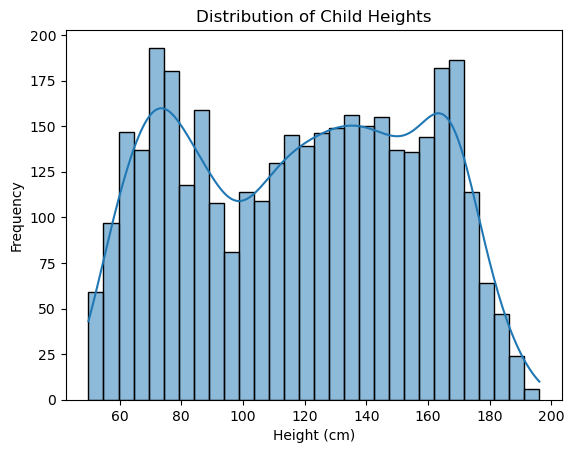

In [12]:
# Distribution of target variable (height)
sns.histplot(gen2_train['SHgt_cm'].dropna(), bins=30, kde=True)
plt.title("Distribution of Child Heights")
plt.xlabel("Height (cm)")
plt.ylabel("Frequency")
plt.show()

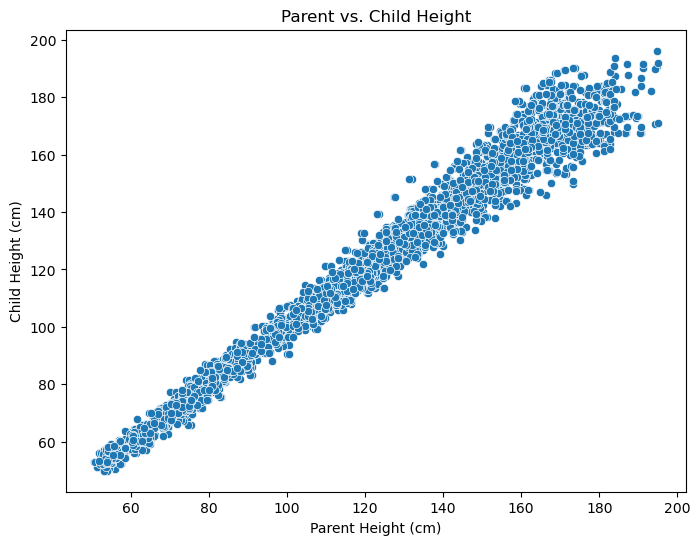

In [13]:
# Relationship between Parent and Child Heights
parent_data = prepare_parent_data(gen1_train, gen1_test)
merged = pd.merge(gen2_train, parent_data, left_on=['study_parent_id_new', 'AgeGr'], right_on=['gen1_id', 'parent_age'], how='left')

plt.figure(figsize=(8,6))
sns.scatterplot(x=merged['parent_height'], y=merged['SHgt_cm'])
plt.xlabel("Parent Height (cm)")
plt.ylabel("Child Height (cm)")
plt.title("Parent vs. Child Height")
plt.show()

/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_93039/1380837180.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(gen2_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")


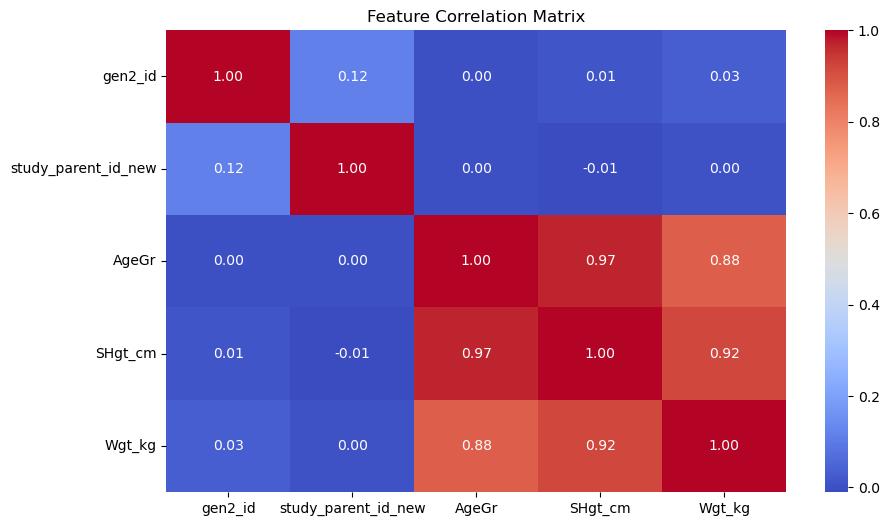

In [14]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gen2_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

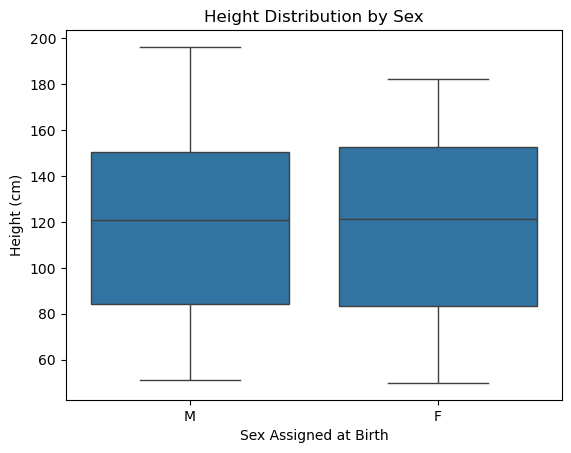

In [15]:
# Gender-based height distribution
sns.boxplot(x=gen2_train['sex_assigned_at_birth'], y=gen2_train['SHgt_cm'])
plt.xlabel("Sex Assigned at Birth")
plt.ylabel("Height (cm)")
plt.title("Height Distribution by Sex")
plt.show()

# BMI distribution if available
if 'bmi' in gen2_train.columns:
    sns.histplot(gen2_train['bmi'].dropna(), bins=30, kde=True)
    plt.title("Distribution of BMI")
    plt.xlabel("BMI")
    plt.ylabel("Frequency")
    plt.show()

In [19]:
def plot_feature_distributions(feature_df):
    """Visualize distributions and relationships of generated features."""
    
    # Histogram of key continuous features
    continuous_features = ['growth_velocity', 'height_diff_9_6', 'height_diff_12_9', 
                           'growth_rate_change', 'peak_growth_rate', 'parent_child_height_ratio']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(continuous_features):
        sns.histplot(feature_df[feature].dropna(), bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(feature_df[continuous_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlations")
    plt.show()
    
    # Boxplot of height differences by gender
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=feature_df, x='is_male', y='height_diff_9_6')
    plt.xticks([0, 1], ['Female', 'Male'])
    plt.title("Height Difference (9-6 years) by Gender")
    plt.show()

    # Scatter plot: Parent height vs. child's last height
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=feature_df, x='parent_height_18', y='last_height', hue='is_male', alpha=0.7)
    plt.xlabel("Parent Height at 18")
    plt.ylabel("Child's Last Measured Height")
    plt.title("Parent Height vs. Child Height")
    plt.legend(title="Male")
    plt.show()

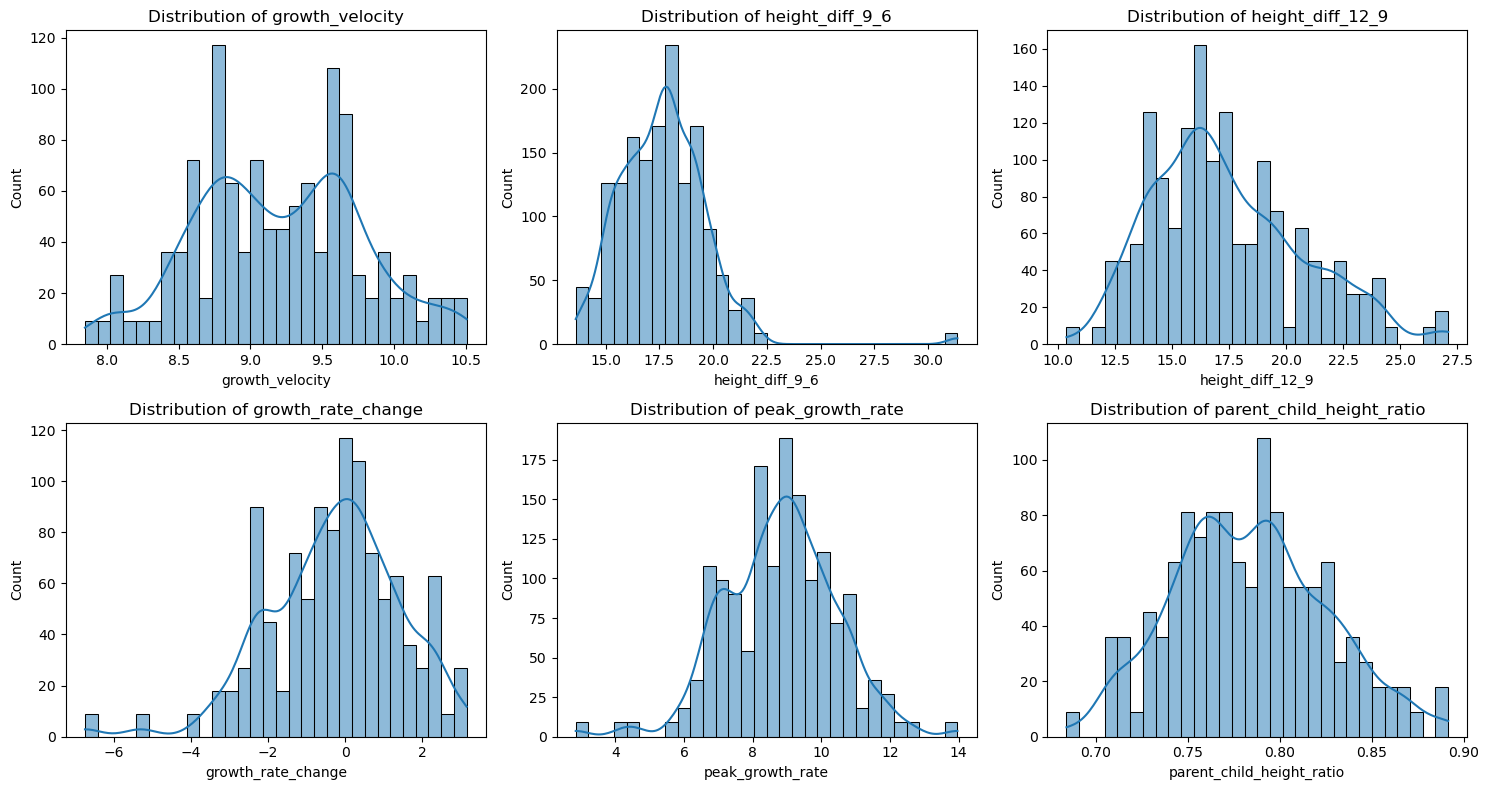

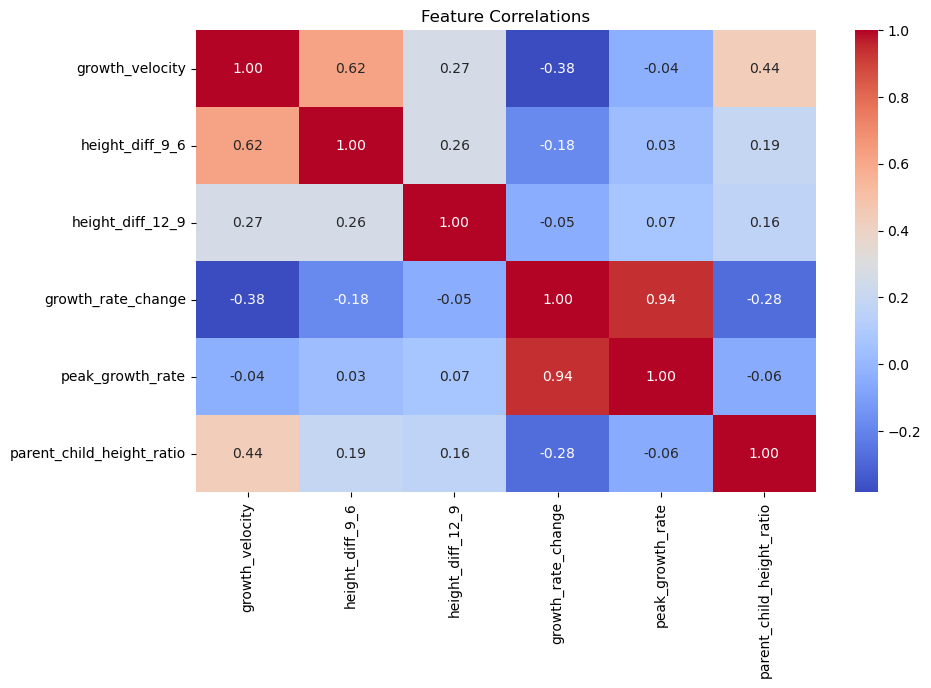

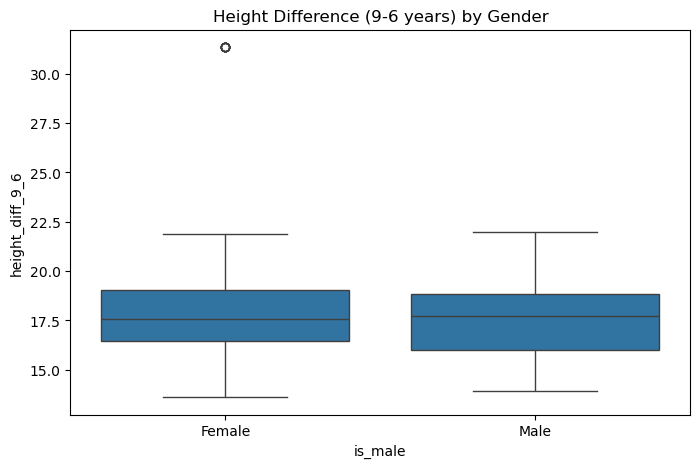

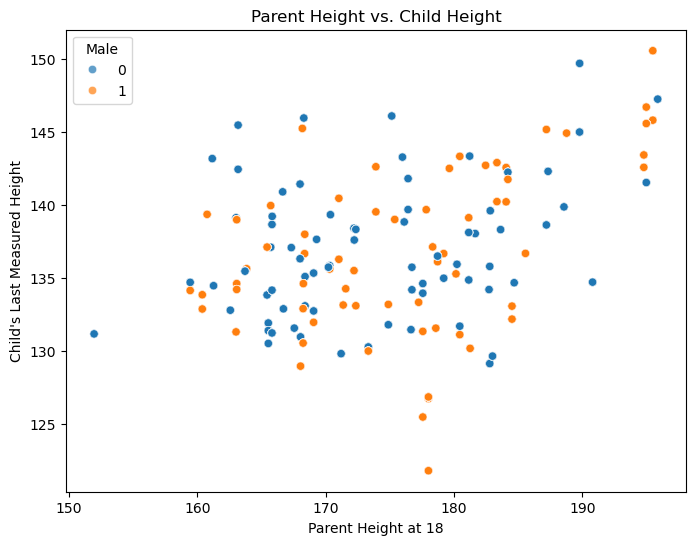

In [20]:
parent_heights = prepare_parent_data(gen1_train, gen1_test)
train_features = create_features(gen2_train, parent_heights)

plot_feature_distributions(train_features)

# Training the Model and Getting Evaluation Results

In [ ]:
def main():
    """Main execution function"""
    # Load data
    data_dir = 'csv/input'
    gen1_train, gen2_train, gen1_test, gen2_test = load_data(data_dir)
    print("Data loaded successfully")
    
    # Prepare parent data
    parent_heights = prepare_parent_data(gen1_train, gen1_test)
    print(f"Parent data prepared: {parent_heights.shape[0]} entries")
    
    # Create features
    print("Creating training features...")
    train_features = create_features(gen2_train, parent_heights)
    print(f"Training features created: {train_features.shape}")
    
    # Add target variable
    train_features = prepare_train_data(train_features, gen2_train)
    print(f"Training data with target: {train_features.shape}")
    
    # Train and evaluate model
    print("Training model...")
    model, preprocessor, feature_cols, val_results = train_model(train_features)
    
    # Visualize model performance
    print("Creating visualizations...")
    visualize_model(model, val_results, feature_cols)
    
    # Create test features
    print("Creating test features...")
    test_features = create_features(gen2_test, parent_heights)
    print(f"Test features created: {test_features.shape}")
    
    # Generate predictions
    print("Generating predictions...")
    submission = generate_predictions(model, test_features, preprocessor, feature_cols, data_dir, 'gen2_test_solution_template.csv')
    
    # Save submission file
    output_path = 'height_prediction_submission5.csv'
    submission.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")
    print(f"Submission shape: {submission.shape}")


if __name__ == "__main__":
    main() 

Data loaded successfully
Parent data prepared: 5342 entries
Creating training features...
Training features created: (1728, 18)
Training data with target: (1293, 19)
Training model...


/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_1757/1709111259.py:240: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  train_with_target = pd.merge(


Fitting 4 folds for each of 1024 candidates, totalling 4096 fits
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 250, 'reg_alpha': 0.15, 'reg_lambda': 0.25, 'scale_pos_weight': 1.8, 'subsample': 0.7}
[0]	train-rmse:12.93349	eval-rmse:11.91996
[1]	train-rmse:12.38593	eval-rmse:11.40933
[2]	train-rmse:11.86404	eval-rmse:10.92696
[3]	train-rmse:11.38430	eval-rmse:10.48343
[4]	train-rmse:11.27859	eval-rmse:10.40341
[5]	train-rmse:10.82115	eval-rmse:10.00298
[6]	train-rmse:10.38648	eval-rmse:9.58949
[7]	train-rmse:9.96973	eval-rmse:9.22625
[8]	train-rmse:9.86562	eval-rmse:9.16155
[9]	train-rmse:9.46984	eval-rmse:8.79258
[10]	train-rmse:9.09627	eval-rmse:8.46637
[11]	train-rmse:8.75311	eval-rmse:8.15826
[12]	train-rmse:8.42165	eval-rmse:7.85430
[13]	train-rmse:8.09650	eval-rmse:7.58142
[14]	train-rmse:7.78262	eval-rmse:7.29772
[15]	train-rmse:7.70491	eval-rmse:7.24064
[16]	train-rmse:7.41747	eval-rmse:6.9

<Figure size 1200x600 with 0 Axes>